# Import the Packages and Survey Data

In [2]:
from data.echogram import DataReaderZarr, get_data_readers
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt

dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = '/data/'

#  Get list of relevant surveys
surveys = ['2019/S2019847/ACOUSTIC/GRIDDED/S2019847_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y

# Necessary Functions

In [502]:
# Necessary Functions
def db(data, eps=1e-10):
    return 10 * np.log10(data + eps)

def db_with_limits(data, limit_low=-75, limit_high=0): # Function for numpy arrays
    data = db(data)
    data[data>limit_high] = limit_high
    data[data<limit_low] = limit_low
    return data

def xr_db_with_limits(xarr, limit_low=-75, limit_high=0): # Function to be applied to xarray dataarray
    data = db(xarr)
    result = data.where((data<limit_high) | (data.isnull()), limit_high)
    result = result.where((result>limit_low) | (result.isnull()), limit_low)
    return result

# Example Illustration for a patch - Echogram, annotations, Background Sv Distribution
def examp_illustr(survey, x, y, fig_start=-75, fig_finish=5, s_bin=5, db_w_limit=True, patch_size=[256, 256]):
    
    c = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                               idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                               return_numpy=True)
    if db_w_limit:
        a = xr_db_with_limits(survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                                    idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                                    return_numpy=False, frequencies=[38000]))
        echo = a[0,:,:].values
        bg = a[0].values[np.logical_or(c==-1, c==0)] # Background
        
    else:
        a = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                  idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                  return_numpy=False, frequencies=[38000])
        echo = db(a[0,:,:].values)
        bg = db(a[0].values[np.logical_or(c==-1, c==0)]) # Background             
        
        
        
    print('mean background Sv =', bg.mean(), ' median background Sv =', np.median(bg))
    print('mean Sandeel Sv =', a[0].values[c==27].mean(), ' median Sandeel Sv =', np.median(a[0].values[c==27]))
    # Echogram Plot
    plt.figure(figsize = (12,12))
    plt.suptitle('Patch Visualization at x='+str(x)+' and y='+str(y))
    
    plt.subplot(2,2,1)
    plt.title('Echogram')
    plt.imshow(echo.T)
    plt.colorbar()
    
    # Annotation Plot
    plt.subplot(2,2,3)
    plt.title('Annotations')
    plt.imshow(c.T)
    plt.colorbar()
        
    # Background Histogram Plot
    plt.subplot(2,2,2)
    plt.title('Background Sv Histogram')
    plt.hist(bg.flatten(), bins = np.arange(fig_start, fig_finish, s_bin), log = False)
    plt.xlabel('sv')
    plt.ylabel('Counts')
    plt.axvline(x=bg.mean(), color = 'black', label = 'mean')
    plt.axvline(x=np.median(bg), color = 'green', label = 'median')
    plt.axvline(x=np.nanpercentile(bg, 25), color = 'lightgray', label = '25 Percentile')
    plt.axvline(x=np.nanpercentile(bg, 75), color = 'dimgray', label = '75 Percentile')
    plt.legend()
        
    # Sandeel Histogram Plot
    plt.subplot(2,2,4)
    plt.title('Sandeel Sv Histogram')
    plt.hist(echo[c==27].flatten(),
             bins = np.arange(fig_start, fig_finish, s_bin), log = False)        
    plt.xlabel('Sv')
    plt.ylabel('Counts')
    plt.axvline(x=(echo[c==27].flatten()).mean(), color = 'red', label = 'Sandeel mean Sv')
    plt.axvline(x=np.median((echo[c==27].flatten())), color = 'orange', label = 'Sandeel median Sv')
    plt.axvline(x=np.nanpercentile(echo[c==27].flatten(), 25), color = 'lightgray', label = '25 Percentile')
    plt.axvline(x=np.nanpercentile(echo[c==27].flatten(), 75), color = 'dimgray', label = '75 Percentile')
    plt.legend()
    plt.show()    
    
    
# Histogram Plot Function (2 Different Axes, 2 Different Distributions)

def hist_2_axis(pdata, x1, x2, fig_start = -80, fig_finish = -3, s_bin = 2, col1='blue', col2='green',
               y1label = 'Mean Sandeel Sv', y2label = 'Mean Background Sv', xlabel="Mean Sv in dB re 1m^(-1)",
               cond = (pdata['nop_sandeel'] != 0)):    
    
    bins = np.arange(fig_start, fig_finish, s_bin)

    fig,ax = plt.subplots(figsize = (12,9))
    plt.rcParams["axes.linewidth"] = 0.2
    plt.rcParams["axes.edgecolor"] = "black"
    plt.title(y1label+' and '+y2label)
    ax.hist(pdata[cond][x1], bins = bins,
            label = y1label, color=col1, alpha=0.5, rwidth=0.9)

    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(y1label+' Count', color=col1, fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(0.88, 0.95))
    plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
    
    
    ax2=ax.twinx()
    ax2.hist(pdata[x2], bins = bins, alpha = 0.5,
             label = y2label, color=col2, log=False, rwidth=0.9)
    ax2.set_ylabel(y2label+' Count', color=col2, fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(0.88, 0.9))
    plt.xticks(np.arange(fig_start, fig_finish+1, s_bin*3))
    plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
    plt.show()

# dB Domain - Analyzing the Near Surface Area (Height)

# NEAR FIELD CALCULATION HERE

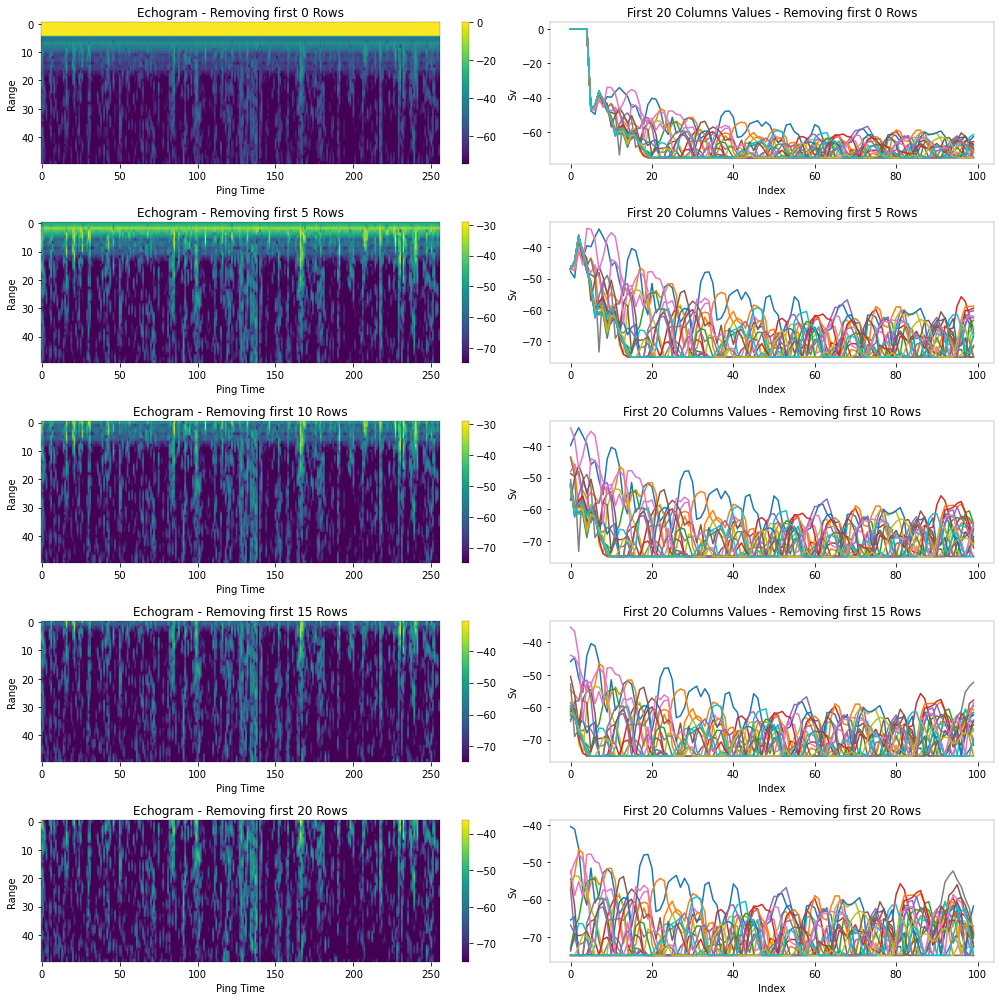

In [228]:
survey = readers[0]
remove_near_surface = [0, 5, 10, 15, 20] # Number of pixels removed vertically from sea surface
plt.figure(figsize = (14,14))
for i in range(len(remove_near_surface)):
    x, y = 46976, 128+remove_near_surface[i] 
    deneme = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                               idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                               return_numpy=False, frequencies=[38000])
    aa = db_with_limits(deneme[0].values).astype('float64')
    
    # Subplot for echogram
    plt.subplot(len(remove_near_surface),2,2*i+1)
    plt.title('Echogram - Removing first '+str(remove_near_surface[i])+' Rows')
    plt.imshow(aa.T[0:50], aspect="auto")
    plt.colorbar(fraction=0.05)
    plt.xlabel('Ping Time')
    plt.ylabel('Range')
    
    # Subplot for the Sv Values
    plt.subplot(len(remove_near_surface),2,2*i+2)
    plt.title('First '+str(20)+ ' Columns Values - Removing first '+ str(remove_near_surface[i]) + ' Rows')
    for i in range(20):
        plt.plot(aa.T[0:100,i])
    plt.xlabel('Index')
    plt.ylabel('Sv')

    plt.tight_layout()
    #plt.savefig('near_surface')
    
    

# The Closest Sandeel Pixel to the Sea Surface

In [512]:
# All Acoustic Prediction
import xarray as xr
dd = '/data/2019/S2019847/ACOUSTIC/GRIDDED/S2019847'

sv_fname = dd+'_sv.zarr'
annotations_fname = dd+'_labels.zarr'
schools_fname = dd+'_labels.parquet.csv'
bottom_fname = dd+'_bottom.zarr'

# Open the files
zarr_grid = xr.open_zarr(sv_fname)
zarr_pred = xr.open_zarr(annotations_fname, consolidated = True)
df = pd.read_csv(schools_fname, header=0)

In [226]:
# Summary School Information
nsan, noth, npos = len(df[df['category']==27]), len(df[df['category']==1]), len(df[df['category']==6009])
print('Number of Sandeel Schools = ', nsan, 'Number of Other Schools = ', noth,
      'Number of Sandeel Schools = ', npos)

Number of Sandeel Schools =  2786 Number of Other Schools =  4741 Number of Sandeel Schools =  477


In [7]:
df[df['category']==27].sort_values(by = 'upperdept').head(10) # Sorting Fish School data basedon upperdepth

,ID,object,type,category,proportion,startping,endping,startpingindex,endpingindex,upperdept,lowerdept,upperdeptindex,lowerdeptindex
5546,5547__School-6085,5547,School-6085,27.0,1,2019-05-09 05:08:29.282000,2019-05-09 05:08:32.798000,3099780,3099790,10.108007,9.918057,6,34
5550,5551__School-6086,5551,School-6086,27.0,1,2019-05-09 05:20:48.220000,2019-05-09 05:20:51.376000,3101880,3101889,10.203556,9.823652,6,36
43,44__School-41,44,School-41,27.0,1,2019-04-24 09:13:45.579000,2019-04-24 09:13:57.595000,50952,50964,11.196256,25.842813,30,111
616,617__School-620,617,School-620,27.0,1,2019-04-26 09:33:10.438000,2019-04-26 09:33:21.001000,398384,398414,12.253737,16.784914,23,85
45,46__School-44,46,School-44,27.0,1,2019-04-24 09:25:59.829000,2019-04-24 09:26:24.860000,51605,51627,12.841512,25.706467,29,184
608,609__School-615,609,School-615,27.0,1,2019-04-26 09:31:00.266000,2019-04-26 09:31:03.079000,398014,398022,12.877315,19.893232,27,92
602,603__School-609,603,School-609,27.0,1,2019-04-26 09:06:14.298000,2019-04-26 09:06:22.048000,393790,393812,13.203077,19.528427,29,148
4553,4554__School-5002,4554,School-5002,27.0,1,2019-05-06 05:58:06.657000,2019-05-06 05:58:20.720000,2389971,2390011,14.182439,14.372391,23,210
4858,4859__School-5325,4859,School-5325,27.0,1,2019-05-07 08:42:16.407000,2019-05-07 08:42:25.985000,2659779,2659806,14.635820,15.585581,38,137
88,89__School-84,89,School-84,27.0,1,2019-04-24 12:13:42.579000,2019-04-24 12:13:47.391000,62839,62845,15.014408,28.778046,58,135


# Nils Olav'a Sorulacak - Upped Depth Index and Upper Dept Contradiction

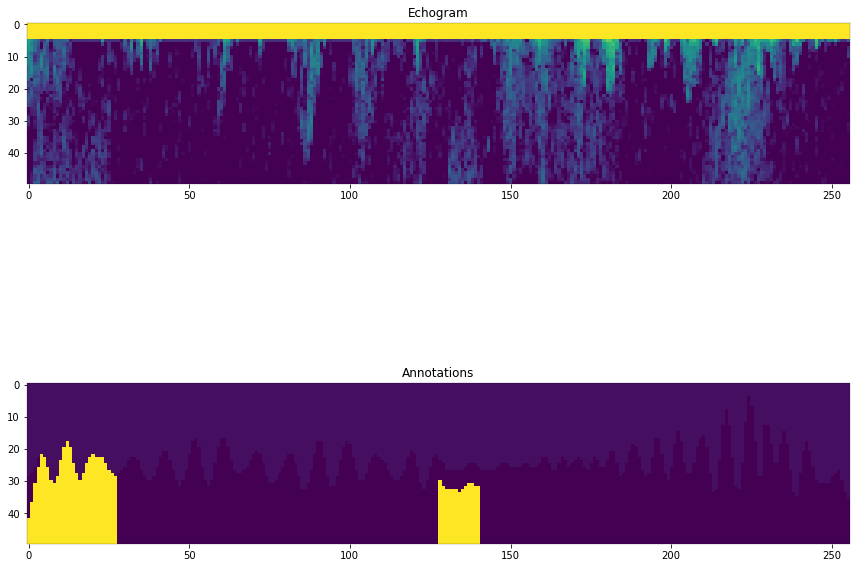

In [255]:
# Upped Depth Index and Upper Dept Contradiction - Nils Olav'a Sorulacak

# !! Only the fish schools at index 3099780, and 3101880 have pixels above 20 threshold

x, y = 50952, 128 

a = xr_db_with_limits(survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=False, frequencies=[200000]))
c = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=True)

thr = 0
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.title('Echogram')
plt.imshow(a[0,:,:].values.T[thr:50,:])
#plt.colorbar()
plt.subplot(2,1,2)
plt.title('Annotations')
plt.imshow(c.T[thr:50,:])
plt.tight_layout()
#plt.colorbar()

plt.show()


# Example Ilustrations before Extracting the Patch Information

mean background Sv = -71.70924  median background Sv = -75.0
mean Sandeel Sv = -63.975594  median Sandeel Sv = -66.2623


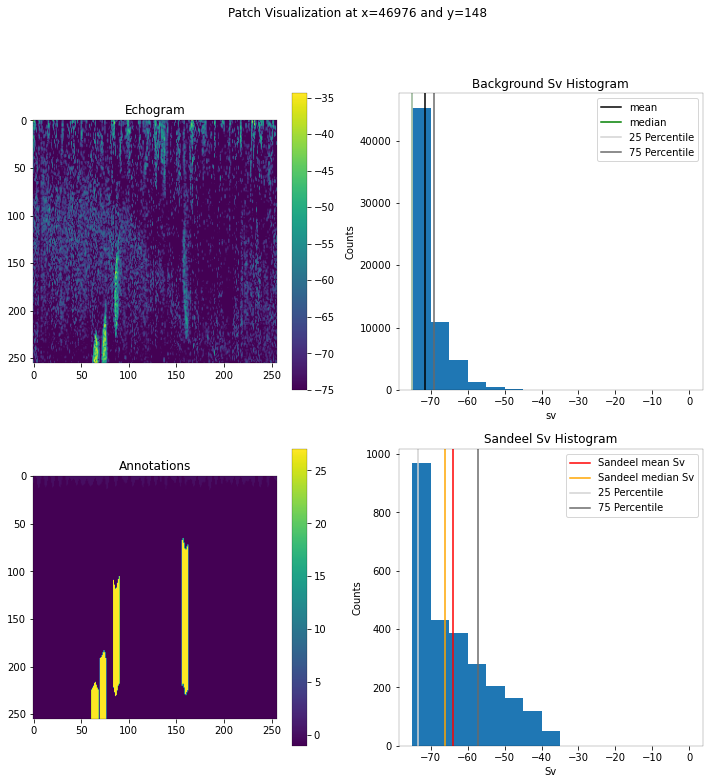

In [256]:
examp_illustr(survey, x=46976, y=148, fig_start=-75, fig_finish=5, 
              s_bin=5, db_w_limit=True, patch_size=[256, 256])

# Creating Coordinates and Metadata Structure

In [10]:
survey = readers[0]

exc_pix_vert = 20 # Vertically excluded pixels

n_pings, n_range = survey.shape

xs = np.arange(patch_size[0] // 2, n_pings - patch_size[0] // 2, patch_size[0])
ys = np.arange(exc_pix_vert + patch_size[1] // 2, patch_size[1] * 3 - patch_size[1] // 2, patch_size[1])

(xs, ys) = np.meshgrid(xs, ys)
coordinate_list = np.array([xs.ravel(), ys.ravel()]).T[:-2,:] # Last two rows excluded

fish_categories = list(survey.fish_categories)


# Producing Metadata for Each Patch Through the Survey Data

In [11]:

# x, y, mean, median, n_pixels_below_seabed, Nr of fish categories + ignore + background
data = np.zeros((len(coordinate_list), 2 + 3 + len(survey.fish_categories) + 15))  ## UPDATE EDILECEK

for i, (x, y) in tqdm(enumerate(coordinate_list), total=len(coordinate_list)):
    data[i, 0] = x
    data[i, 1] = y

    data_Sv = xr_db_with_limits(survey.get_data_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                                      idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                                      return_numpy=False,
                                                      frequencies=[38000]))  # Calculating Sv with limits
    mean_Sv = data_Sv.mean().values
    median_Sv = data_Sv.median(dim=['ping_time', 'range']).values

    data[i, 2] = mean_Sv  # Mean Sv value
    data[i, 3] = median_Sv  # Median Sv value

    seabed_mask = survey.get_seabed_mask(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                          idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                          return_numpy=False)
    n_pixels_below_seabed = seabed_mask.sum().values
    data[i, 4] = n_pixels_below_seabed  # Pixels under seabed

    labels = survey.annotation.annotation[:, (x - patch_size[0] // 2):(x + patch_size[0] // 2),
             int(y - patch_size[1] // 2):int(y + patch_size[1] // 2)]

    # Number of Pixels
    data[i, 5] = labels.sel(category=1).sum().values  # Other class
    data[i, 6] = labels.sel(category=27).sum().values  # Sandeel class
    data[i, 7] = labels.sel(category=6009).sum().values  # Possible Sandeel class
    data[i, 8] = 256 * 256 - (data_Sv * data_Sv.isnull()).count().values  # Number of nan pixels
    data[i, 9] = 256 * 256 - (
                data[i, 5] + data[i, 6] + data[i, 7] + data[i, 8])  # Background class (Excluding nan values)

    # Average Intensity Values
    if data[i, 5] != 0: 
        data[i, 10] = ((data_Sv * labels.sel(category=1)).sum() / data[i, 5]).values  # Average Other Sv
        # Assigning std, 25 percentile and 75 percentile
        sd_Ot = data_Sv[0].values[labels.sel(category=1) == 1]
        data[i, 14], data[i, 15], data[i, 16] = np.nanstd(sd_Ot), np.percentile(sd_Ot, 25), np.percentile(sd_Ot, 75)
        
    if data[i, 6] != 0: 
        data[i, 11] = ((data_Sv * labels.sel(category=27)).sum() / data[i, 6]).values  # Average Sandeel Sv
        # Assigning std, 25 percentile and 75 percentile
        sd_Sd = data_Sv[0].values[labels.sel(category=27) == 1]
        data[i, 17], data[i, 18], data[i, 19] = np.nanstd(sd_Sd), np.nanpercentile(sd_Sd, 25), np.nanpercentile(sd_Sd, 75)
        
    if data[i, 7] != 0: data[i, 12] = (
        (data_Sv * labels.sel(category=6009)).sum() / data[i, 7]).values  # Average Possible Sandeel Sv
    if data[i, 9] == 256 * 256:
        data[i, 13] = mean_Sv
        # Assigning std, 25 percentile and 75 percentile
        sd_Bg = data_Sv[0].values
        data[i, 20], data[i, 21], data[i, 22] = np.nanstd(sd_Bg), np.nanpercentile(sd_Bg, 25), np.nanpercentile(sd_Bg, 75)
    else:
        sd_Bg = data_Sv[0].values[np.logical_and(labels.sel(category=27).values != 1,
                                                 labels.sel(category=1).values != 1,
                                                 labels.sel(category=6009).values != 1)]
        data[i, 13] = np.nansum(sd_Bg) / data[i, 9]  # Average Background Sv - Excluding nan values
        # Assigning std, 25 percentile and 75 percentile
        data[i, 20], data[i, 21], data[i, 22] = np.nanstd(sd_Bg), np.nanpercentile(sd_Bg, 25), np.nanpercentile(sd_Bg, 75)


 27%|██▋       | 8287/31128 [5:43:14<13:17:16,  2.09s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 52%|█████▏    | 16233/31128 [11:07:22<13:48:08,  3.34s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 78%|███████▊  | 24320/31128 [18:39:44<6:10:21,  3.26s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variabl

# Saving & Loading the Data

In [356]:
#np.savetxt("Sv_patch_data.csv", data, delimiter=",")
Sv_data = np.loadtxt('Sv_patch_data.csv', delimiter=",")

pdata = pd.DataFrame(Sv_data)
names = ['x', 'y', 'mean_Sv', 'median_Sv', 
         'nop_below_seabed', 'nop_other', 'nop_sandeel', 'nop_possandeel', 'nop_nan',
         'nop_background', 'mean_other', 'mean_sandeel', 'mean_possandeel', 'mean_background',
         'std_other', '25_other', '75_other',
         'std_sandeel', '25_sandeel', '75_sandeel',
        'std_background', '25_background', '75_background']
pdata.columns = names
pdata[pdata['nop_sandeel']>=0].head()
#pdata.info()

,x,y,mean_Sv,median_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,...,mean_background,std_other,25_other,75_other,std_sandeel,25_sandeel,75_sandeel,std_background,25_background,75_background
0,128.0,148.0,-73.024147,-75.0,0.0,0.0,0.0,0.0,0.0,65536.0,...,-73.024147,0.0,0.0,0.0,0.0,0.0,0.0,3.740309,-75.0,-72.643904
1,384.0,148.0,-72.961578,-75.0,0.0,0.0,0.0,0.0,0.0,65536.0,...,-72.961578,0.0,0.0,0.0,0.0,0.0,0.0,3.817220,-75.0,-72.542253
2,640.0,148.0,-73.257332,-75.0,0.0,0.0,0.0,0.0,0.0,65536.0,...,-73.257332,0.0,0.0,0.0,0.0,0.0,0.0,3.570127,-75.0,-73.920282
3,896.0,148.0,-74.101067,-75.0,0.0,0.0,0.0,0.0,0.0,65536.0,...,-74.101067,0.0,0.0,0.0,0.0,0.0,0.0,2.439322,-75.0,-75.000000
4,1152.0,148.0,-74.086021,-75.0,0.0,0.0,0.0,0.0,0.0,65536.0,...,-74.086021,0.0,0.0,0.0,0.0,0.0,0.0,2.553980,-75.0,-75.000000


# Summary Patch Information

In [506]:
sb = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Sandeel + Background
so = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Sandeel + Other
sp = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel
spo = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel + Other

ob = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Other + Background
op = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Other + Possandeel
pb = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Possandeel + Background

b = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Possandeel + Background

info = np.array([sb, so, sp, spo, ob, op, pb, b], ndmin = 2)
names = np.array(['Sand, Bg', 'Sand, Oth', 'Sand, PosSand', 'Sand, PosSand, Bg',
                      'Oth, Bg', 'Oth, PosSand', 'PosSand, Bg', 'Bg'], ndmin = 2)
info, names

(array([[ 1349,   533,    32,    97,  1854,   169,   102, 26992]]),
 array([['Sand, Bg', 'Sand, Oth', 'Sand, PosSand', 'Sand, PosSand, Bg',
         'Oth, Bg', 'Oth, PosSand', 'PosSand, Bg', 'Bg']], dtype='<U17'))

# Histogram Plots

# Mean Background and Fish School Sv Distributions

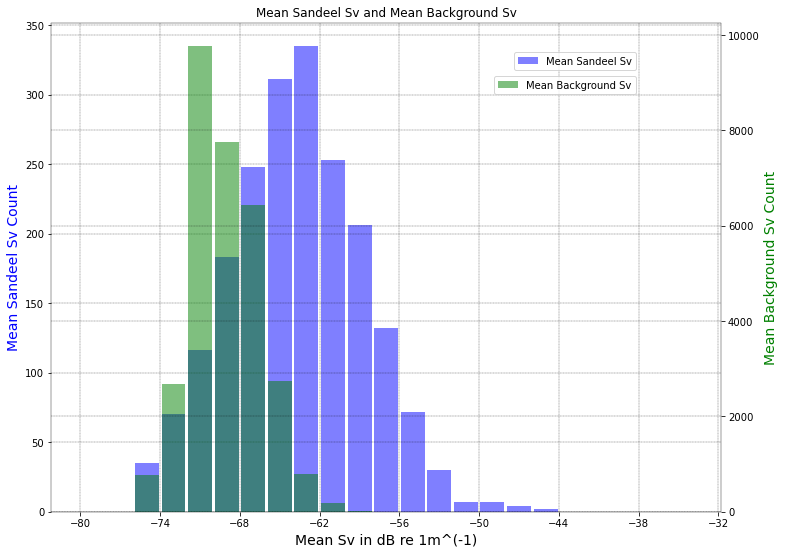

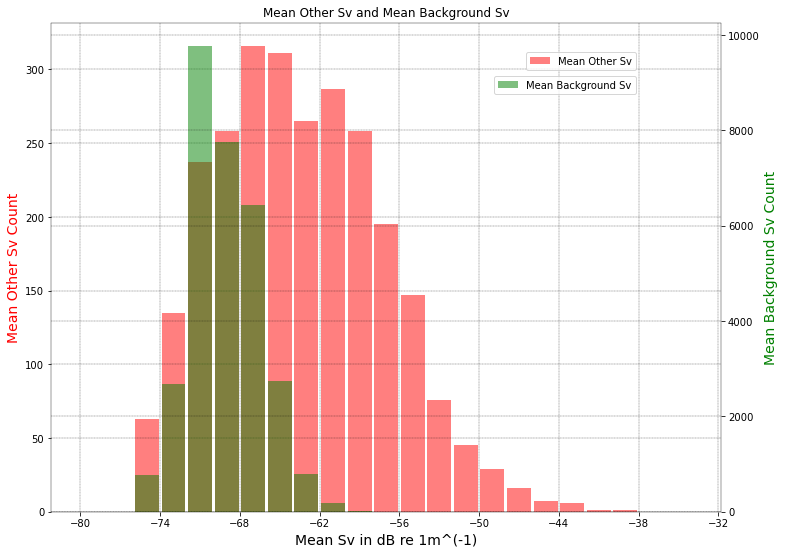

In [504]:
# Mean Values Plot
hist_2_axis(pdata, 'mean_sandeel', 'mean_background', fig_finish = -32, s_bin = 2,
            y1label = 'Mean Sandeel Sv', y2label = 'Mean Background Sv', 
            xlabel="Mean Sv in dB re 1m^(-1)", cond = (pdata['nop_sandeel'] != 0))
hist_2_axis(pdata, 'mean_other', 'mean_background', fig_finish = -32, s_bin = 2,
            y1label = 'Mean Other Sv', y2label = 'Mean Background Sv', 
            xlabel="Mean Sv in dB re 1m^(-1)", cond = (pdata['nop_other'] != 0), col1='red')

In [508]:
# High Background Pixels (Zooplanktons here - nop_below_seabed<0 and close to the surface)
pdata.sort_values(by='mean_background', ascending=False).head(10)

,x,y,mean_Sv,median_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,...,mean_background,std_other,25_other,75_other,std_sandeel,25_sandeel,75_sandeel,std_background,25_background,75_background
30553,3837056.0,404.0,-59.274586,-59.499542,19207.0,45.0,0.0,18.0,0.0,65473.0,...,-59.294075,7.923492,-59.948769,-47.972595,0.0,0.0,0.0,11.519003,-65.553562,-55.324493
30568,3840896.0,404.0,-59.725693,-60.361488,18908.0,144.0,0.0,0.0,0.0,65392.0,...,-59.732769,8.823729,-61.998906,-50.211593,0.0,0.0,0.0,11.381167,-65.959726,-55.976132
15385,3938688.0,148.0,-59.747452,-58.577766,0.0,0.0,0.0,0.0,0.0,65536.0,...,-59.747452,0.000000,0.000000,0.000000,0.0,0.0,0.0,6.740470,-63.431708,-54.886183
15404,3943552.0,148.0,-59.758457,-58.255676,0.0,0.0,0.0,0.0,0.0,65536.0,...,-59.758457,0.000000,0.000000,0.000000,0.0,0.0,0.0,7.609642,-64.031872,-54.168175
15384,3938432.0,148.0,-59.899563,-58.225815,0.0,0.0,0.0,0.0,0.0,65536.0,...,-59.899563,0.000000,0.000000,0.000000,0.0,0.0,0.0,7.480749,-63.933967,-54.345251
8188,2096256.0,148.0,-59.913486,-61.228664,7903.0,0.0,0.0,0.0,0.0,65536.0,...,-59.913486,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.586782,-65.980011,-56.366182
30552,3836800.0,404.0,-59.916035,-60.415649,19980.0,0.0,0.0,0.0,0.0,65536.0,...,-59.916035,0.000000,0.000000,0.000000,0.0,0.0,0.0,11.613592,-66.412565,-55.987419
30569,3841152.0,404.0,-59.919998,-61.078239,12226.0,0.0,0.0,0.0,0.0,65536.0,...,-59.919998,0.000000,0.000000,0.000000,0.0,0.0,0.0,11.156307,-65.619673,-56.930561
30554,3837312.0,404.0,-60.277012,-60.645737,20045.0,205.0,0.0,20.0,0.0,65311.0,...,-60.309913,6.949372,-59.757423,-51.632137,0.0,0.0,0.0,11.566785,-66.754990,-56.377386
30555,3837568.0,404.0,-60.317169,-60.846214,21447.0,80.0,0.0,27.0,0.0,65429.0,...,-60.349016,6.425065,-58.088055,-50.903253,0.0,0.0,0.0,11.721104,-67.101830,-56.285798


# Percentile Background and Fish School Sv Distributions

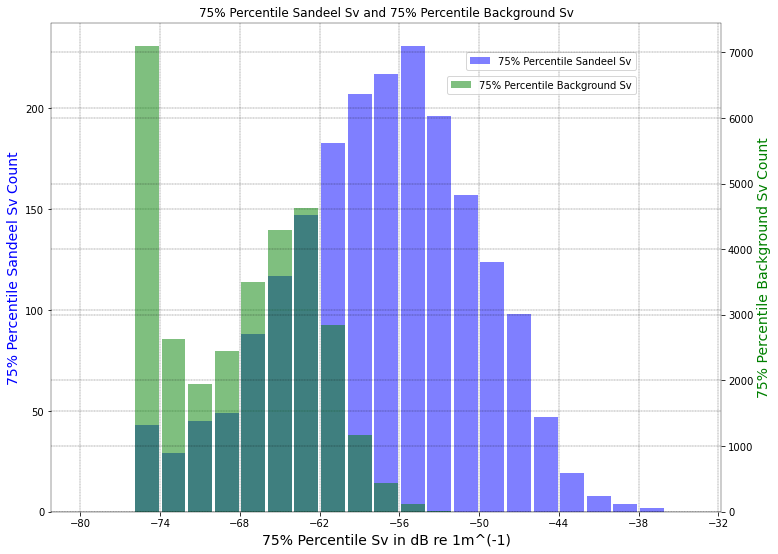

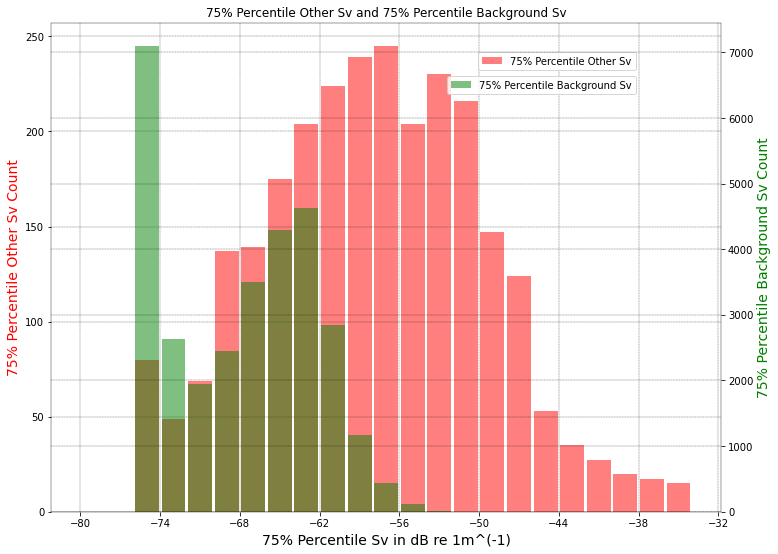

In [505]:
# Percentile Plots
hist_2_axis(pdata, '75_sandeel', '75_background', fig_start = -80, fig_finish = -32, col1='blue',
            y1label = '75% Percentile Sandeel Sv', y2label = '75% Percentile Background Sv', 
            xlabel="75% Percentile Sv in dB re 1m^(-1)", cond = (pdata['nop_sandeel'] != 0))
hist_2_axis(pdata, '75_other', '75_background', fig_finish = -32, s_bin = 2, col1='red',
            y1label = '75% Percentile Other Sv', y2label = '75% Percentile Background Sv', 
            xlabel="75% Percentile Sv in dB re 1m^(-1)", cond = (pdata['nop_other'] != 0))

# Patches Containing Seabed Analysis

In [509]:
# Patches containing seabed filter - Not completely below the seabed
pdata[(pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']<256*256)].sort_values(by = 'mean_background')

,x,y,mean_Sv,median_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,...,mean_background,std_other,25_other,75_other,std_sandeel,25_sandeel,75_sandeel,std_background,25_background,75_background
23514,2035072.0,404.0,-75.000000,-75.000000,15360.0,0.0,0.0,0.0,1536.0,64000.0,...,-75.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.001313,-75.000000,-75.000000
23515,2035328.0,404.0,-74.999901,-75.000000,13824.0,0.0,0.0,0.0,1536.0,64000.0,...,-74.999898,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.013132,-75.000000,-75.000000
23511,2034304.0,404.0,-74.986870,-75.000000,8448.0,0.0,0.0,0.0,1536.0,64000.0,...,-74.986867,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.230618,-75.000000,-75.000000
23473,2024576.0,404.0,-74.967491,-75.000000,256.0,0.0,0.0,0.0,1536.0,64000.0,...,-74.967492,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.603123,-75.000000,-75.000000
23469,2023552.0,404.0,-74.963120,-75.000000,512.0,0.0,0.0,0.0,1536.0,64000.0,...,-74.963117,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.448744,-75.000000,-75.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30569,3841152.0,404.0,-59.919998,-61.078239,12226.0,0.0,0.0,0.0,0.0,65536.0,...,-59.919998,0.000000,0.000000,0.000000,0.0,0.0,0.0,11.156307,-65.619673,-56.930561
30552,3836800.0,404.0,-59.916035,-60.415649,19980.0,0.0,0.0,0.0,0.0,65536.0,...,-59.916035,0.000000,0.000000,0.000000,0.0,0.0,0.0,11.613592,-66.412565,-55.987419
8188,2096256.0,148.0,-59.913486,-61.228664,7903.0,0.0,0.0,0.0,0.0,65536.0,...,-59.913486,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.586782,-65.980011,-56.366182
30568,3840896.0,404.0,-59.725693,-60.361488,18908.0,144.0,0.0,0.0,0.0,65392.0,...,-59.732769,8.823729,-61.998906,-50.211593,0.0,0.0,0.0,11.381167,-65.959726,-55.976132


# Patch and Background Distributions Containing Seabed

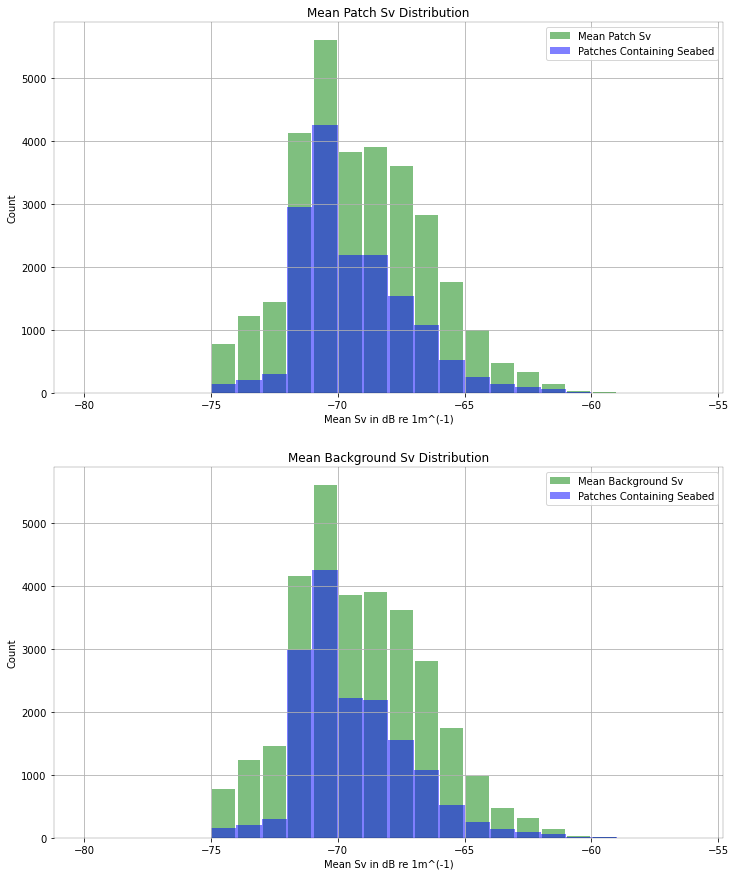

In [485]:

bins2 = np.arange(-80, -55, 1) # Bins and start finish binsize

bg_cont_seabed = pdata[(pdata['nop_below_seabed']>0) & (pdata['nop_below_seabed']<256*256)]

plt.figure(figsize=(12,15))
plt.subplot(2,1,1)
plt.title('Mean Patch Sv Distribution')
plt.hist(pdata['mean_Sv'], color = 'green', bins = bins2, rwidth=0.9,alpha=0.5, label='Mean Patch Sv')
plt.hist(bg_cont_seabed['mean_Sv'], 
         color = 'blue', bins = bins2, histtype='stepfilled',rwidth=0.7,alpha=0.5, label='Patches Containing Seabed')
plt.ylabel('Count')
plt.xlabel('Mean Sv in dB re 1m^(-1)')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.title('Mean Background Sv Distribution')
plt.hist(pdata['mean_background'], color = 'green', bins = bins2, rwidth=0.9,alpha=0.5, label='Mean Background Sv')
plt.hist(bg_cont_seabed['mean_background'], 
         color = 'blue', bins = bins2, histtype='stepfilled',rwidth=0.7,alpha=0.5, label='Patches Containing Seabed')
plt.ylabel('Count')
plt.xlabel('Mean Sv in dB re 1m^(-1)')
plt.grid()
plt.legend()

plt.show()

# Patches Containing Sandeel and Other

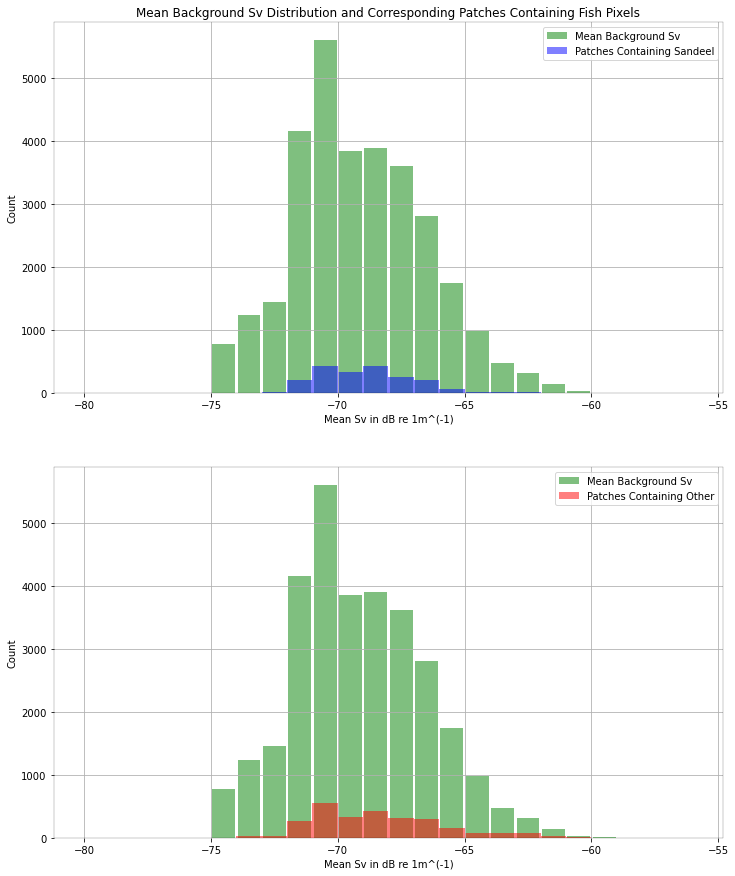

In [463]:

bins2 = np.arange(-80, -55, 1) # Bins and start finish binsize

plt.figure(figsize=(12,15))
plt.subplot(2,1,1)
plt.title('Mean Background Sv Distribution and Corresponding Patches Containing Fish Pixels')
plt.hist(pdata['mean_background'], color = 'green', bins = bins2, alpha = 0.5, label='Mean Background Sv',
        rwidth=0.9)
plt.hist(pdata[pdata['nop_sandeel']>0]['mean_background'], color = 'blue', 
         bins = bins2, histtype='stepfilled', alpha = 0.5, label='Patches Containing Sandeel', rwidth=0.9)
plt.ylabel('Count')
plt.xlabel('Mean Sv in dB re 1m^(-1)')
plt.grid()
plt.legend()
plt.subplot(2,1,2)
plt.hist(pdata['mean_background'], color = 'green', bins = bins2, alpha = 0.5, label='Mean Background Sv', rwidth=0.9)
plt.hist(pdata[pdata['nop_other']>0]['mean_background'], 
         color = 'red', bins = bins2, 
         alpha = 0.5, histtype='stepfilled', label='Patches Containing Other', rwidth=0.9)
plt.grid()
plt.ylabel('Count')
plt.xlabel('Mean Sv in dB re 1m^(-1)')
plt.legend()
plt.show()

In [486]:
# High Background Pixels (Zooplankton here)
pdata.sort_values(by='mean_background', ascending=False).head(10)

,x,y,mean_Sv,median_Sv,nop_below_seabed,nop_other,nop_sandeel,nop_possandeel,nop_nan,nop_background,...,mean_background,std_other,25_other,75_other,std_sandeel,25_sandeel,75_sandeel,std_background,25_background,75_background
30553,3837056.0,404.0,-59.274586,-59.499542,19207.0,45.0,0.0,18.0,0.0,65473.0,...,-59.294075,7.923492,-59.948769,-47.972595,0.0,0.0,0.0,11.519003,-65.553562,-55.324493
30568,3840896.0,404.0,-59.725693,-60.361488,18908.0,144.0,0.0,0.0,0.0,65392.0,...,-59.732769,8.823729,-61.998906,-50.211593,0.0,0.0,0.0,11.381167,-65.959726,-55.976132
15385,3938688.0,148.0,-59.747452,-58.577766,0.0,0.0,0.0,0.0,0.0,65536.0,...,-59.747452,0.000000,0.000000,0.000000,0.0,0.0,0.0,6.740470,-63.431708,-54.886183
15404,3943552.0,148.0,-59.758457,-58.255676,0.0,0.0,0.0,0.0,0.0,65536.0,...,-59.758457,0.000000,0.000000,0.000000,0.0,0.0,0.0,7.609642,-64.031872,-54.168175
15384,3938432.0,148.0,-59.899563,-58.225815,0.0,0.0,0.0,0.0,0.0,65536.0,...,-59.899563,0.000000,0.000000,0.000000,0.0,0.0,0.0,7.480749,-63.933967,-54.345251
8188,2096256.0,148.0,-59.913486,-61.228664,7903.0,0.0,0.0,0.0,0.0,65536.0,...,-59.913486,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.586782,-65.980011,-56.366182
30552,3836800.0,404.0,-59.916035,-60.415649,19980.0,0.0,0.0,0.0,0.0,65536.0,...,-59.916035,0.000000,0.000000,0.000000,0.0,0.0,0.0,11.613592,-66.412565,-55.987419
30569,3841152.0,404.0,-59.919998,-61.078239,12226.0,0.0,0.0,0.0,0.0,65536.0,...,-59.919998,0.000000,0.000000,0.000000,0.0,0.0,0.0,11.156307,-65.619673,-56.930561
30554,3837312.0,404.0,-60.277012,-60.645737,20045.0,205.0,0.0,20.0,0.0,65311.0,...,-60.309913,6.949372,-59.757423,-51.632137,0.0,0.0,0.0,11.566785,-66.754990,-56.377386
30555,3837568.0,404.0,-60.317169,-60.846214,21447.0,80.0,0.0,27.0,0.0,65429.0,...,-60.349016,6.425065,-58.088055,-50.903253,0.0,0.0,0.0,11.721104,-67.101830,-56.285798


# Bottom Data Problematic Parts - Example

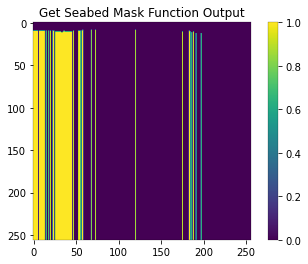

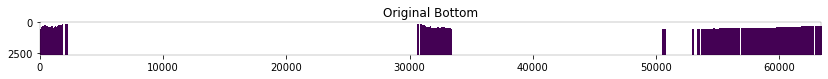

In [461]:
x=2035328
y=148
deneme_mask = survey.get_seabed_mask(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                          idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                          return_numpy=False)
plt.title('Get Seabed Mask Function Output')
plt.imshow(deneme_mask.values.T)
plt.colorbar()

zarr_bottom = xr.open_zarr(bottom_fname)
plt.figure(figsize=(14, 14))
plt.title('Original Bottom')
plt.imshow(zarr_bottom.bottom_range[2031900:2095272,:].values.T)
plt.show()

mean background Sv = -59.758457  median background Sv = -58.255676


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean Sandeel Sv = nan  median Sandeel Sv = nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


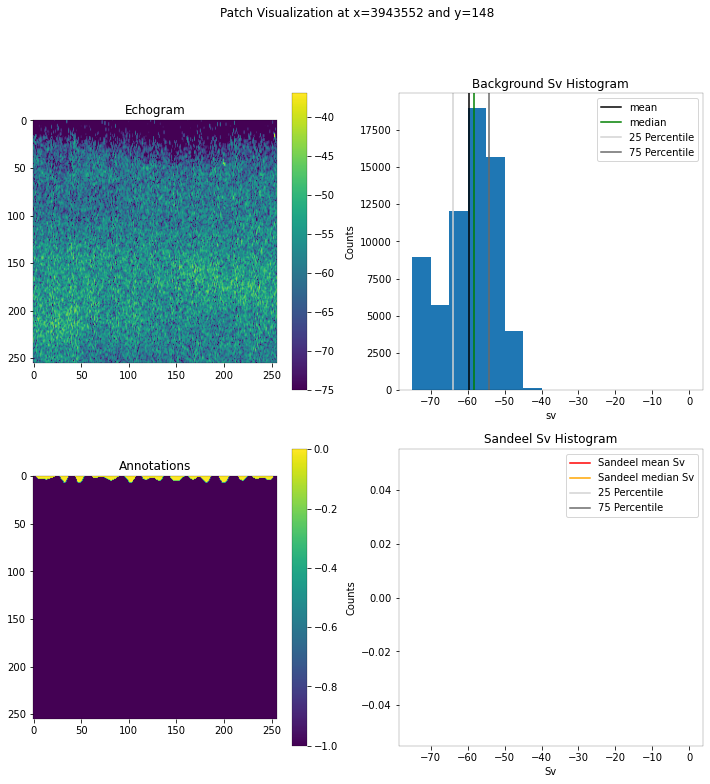

In [470]:
# High Background Values Patch Visualization (max)
max_meanbg = pdata.loc[pdata.idxmax(axis = 0)['mean_background']]['x'].astype('int')
examp_illustr(survey, x=3943552, y=148, fig_start=-75, fig_finish=5, 
              s_bin=5, db_w_limit=True, patch_size=[256, 256])

# Ping Time, Range, and Vessel Velocity

Median Vessel Speed is 9.0 knots
Mean Vessel Speed is 7.353 knots
Median Ping Time is 0.359 seconds
Mean Ping Time is 0.415 seconds


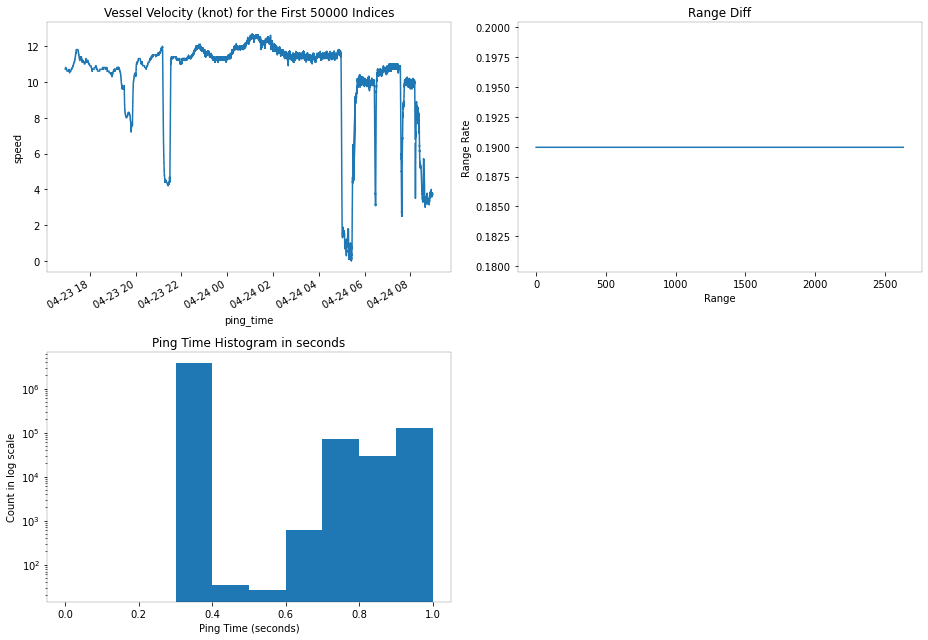

In [567]:
png = np.diff(zarr_grid.ping_time.values).astype('float64')/1000000000

# Vessel Velocity Visualization
print('Median Vessel Speed is '+str(np.nanmedian(zarr_grid.speed.values))+' knots')
print('Mean Vessel Speed is '+str(np.around(np.nanmean(zarr_grid.speed.values), decimals=3))+' knots')
print('Median Ping Time is '+str(np.median(png))+' seconds')
print('Mean Ping Time is '+str(np.around(png.mean(), decimals=3))+' seconds')
frst = 50000
plt.figure(figsize=(13,9))
plt.subplot(2,2,1)
zarr_grid.speed[0:50000].plot()
plt.title('Vessel Velocity (knot) for the First '+str(frst)+' Indices')

plt.subplot(2,2,2)
# Range is constant (0.1899)
plt.plot(np.diff(zarr_grid.range))
plt.title('Range Diff')
plt.xlabel('Range')
plt.ylabel('Range Rate')

# Ping Time Histogram
plt.subplot(2,2,3)
plt.hist(png, log=True, range=(0,1))
plt.title('Ping Time Histogram in seconds')
plt.ylabel('Count in log scale')
plt.xlabel('Ping Time (seconds)')

plt.tight_layout()
plt.show()

0.359